In [1]:
import re
import sys
import os
import math
import json

from operator import itemgetter

import spacy

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

import coreferee

# Add persyn root to sys.path
sys.path.insert(0, '/home/rob/persyn/')
sys.path.insert(0, '/home/rob/persyn/interaction')

from interaction.interact import Interact

from relationships import referee, to_archetype, get_relationships, graph_similarity, jaccard_similarity, edge_similarity, node_similarity

os.environ['PERSYN_CONFIG'] = '/home/rob/persyn/config/spock.yaml'
prefix = 'anna-persyn-spock'

# Bot config
from utils.config import load_config

%matplotlib inline

In [2]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)

In [3]:
interact = Interact(load_config())

In [4]:
nlp = spacy.load('en_core_web_lg')
nlp.add_pipe('coreferee')
nlp.add_pipe('sentencizer')

In [5]:
def show_fig(G, edge_labels=None, summary='', seed=3, figsize=(24, 12)):
    if G.order() == 0:
        return
 
    if edge_labels is None:
        edge_labels = dict([((n1, n2), n3['edge']) for n1, n2, n3 in G.edges(data=True)])

    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=5/math.sqrt(G.order()), seed=seed, iterations=50, weight=None)
    # pos = nx.circular_layout(G)
    
    sources = [n for n in G.nodes() if G.in_degree(n)==0]
    targets = [n for n in G.nodes() if G.out_degree(n)==0]
    others = [n for n in G.nodes if G.out_degree(n) and G.in_degree(n)]

    nx.draw_networkx_edges(G, pos, edge_color='#c0c0c0', arrowsize=50)

    nx.draw_networkx_nodes(G, pos, nodelist=others, node_color='#aaaaaa', node_size=500)
    nx.draw_networkx_nodes(G, pos, nodelist=sources, node_color='#fc8d62', node_size=1000)
    nx.draw_networkx_nodes(G, pos, nodelist=targets, node_color='lightblue', node_size=1000)

    nx.draw_networkx_labels(G, pos, font_color='black', font_size=18)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=18, font_color='black', rotate=True, clip_on=False)


    plt.axis('off')
    plt.title(summary)
    plt.show()

In [6]:
ret = interact.recall.ltm.es.search(
    index=f'{prefix}-conversations-v0', 
    # query={"term": {"channel.keyword": {"value": channel}}},
    query={"match_all": {}},
    aggs={"convo_id":{"terms" : { "field" : "convo_id.keyword" }}},
    size=1000
)

In [12]:
ret['hits']['hits'][0]['_source']['convo_id']

'd8KNhzqnb9nVmGUR9AhxAb'

In [14]:
convo_ids = set()
for hit in ret['hits']['hits']:
    try:
        convo_ids.add(hit['_source']['convo_id'])
    except KeyError:
        continue

In [15]:
len(convo_ids)

60

In [16]:
# All summaries from this channel from the beginning of time
# interact.recall.load(service, channel, summaries=100)

# Import everything

In [17]:
# speakers = set()

for i, convo_id in enumerate(tqdm(convo_ids)):
    convo = interact.recall.ltm.get_convo_by_id(convo_id)

    src = {'summary': ''}

    try:
        summary = interact.recall.ltm.es.search(
            index=f'{prefix}-summaries-v0', 
            query={"term": {"convo_id.keyword": {"value": convo_id}}},
            size=10000
        )['hits']['hits'][0]['_source']['summary']
    except IndexError:
        summary = ''

    # print(f'convo_id: {convo_id}, {len(convo)} lines')

    xformed_lines = []

    # collapse convo es entries into a simple list of sentences, no speakers
    for ret in convo:
        src = ret['_source']
        # Only process dialog
        if src['speaker'].endswith('recalls') or 'remembers' in src['speaker']:
            continue

        # speakers.add(src['speaker'])

        xformed_lines.append(src['msg'])

    relations = []
    for s in nlp(referee(to_archetype(' '.join(xformed_lines)))).sents:
        rels = get_relationships(s)
        if rels:
            relations.append(rels)

    # add all left and right nodes
    the_rels = []
    for relation in relations:
        for rel in relation:
            for left in rel['left']:
                for right in rel['right']:
                    if right == '.':
                        continue
                    the_rels.append((left, right, {'edge': rel['rel']}))

    G = nx.from_edgelist(the_rels, create_using=nx.DiGraph)

    doc = {
        '@timestamp': src['@timestamp'],
        'service': src['service'],
        'channel': src['channel'],
        'convo_id': src['convo_id'],
        'graph': nx.node_link_data(G),
        'convo': ' '.join(xformed_lines),
        'refresh': False
    }

    assert interact.recall.ltm.save_relationship(**doc)['result'] == 'created'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:35<00:00,  1.68it/s]


# A single unified graph

In [18]:
from operator import itemgetter

In [19]:
graphs = []
for convo_id in tqdm(convo_ids):
    ret = interact.recall.ltm.es.search(index=f'{prefix}-conversations-v0', query={"match": {"convo_id": convo_id}}, size=1)
    service, channel = itemgetter('service', 'channel')(ret['hits']['hits'][0]['_source'])
    ret = interact.recall.ltm.lookup_relationship(service, channel, convo_id=convo_id)
    if ret:
        graphs.append(nx.node_link_graph(ret[0]['_source']['graph']))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  6.87it/s]


In [20]:
len(graphs)

60

In [21]:
G = nx.compose_all(graphs)

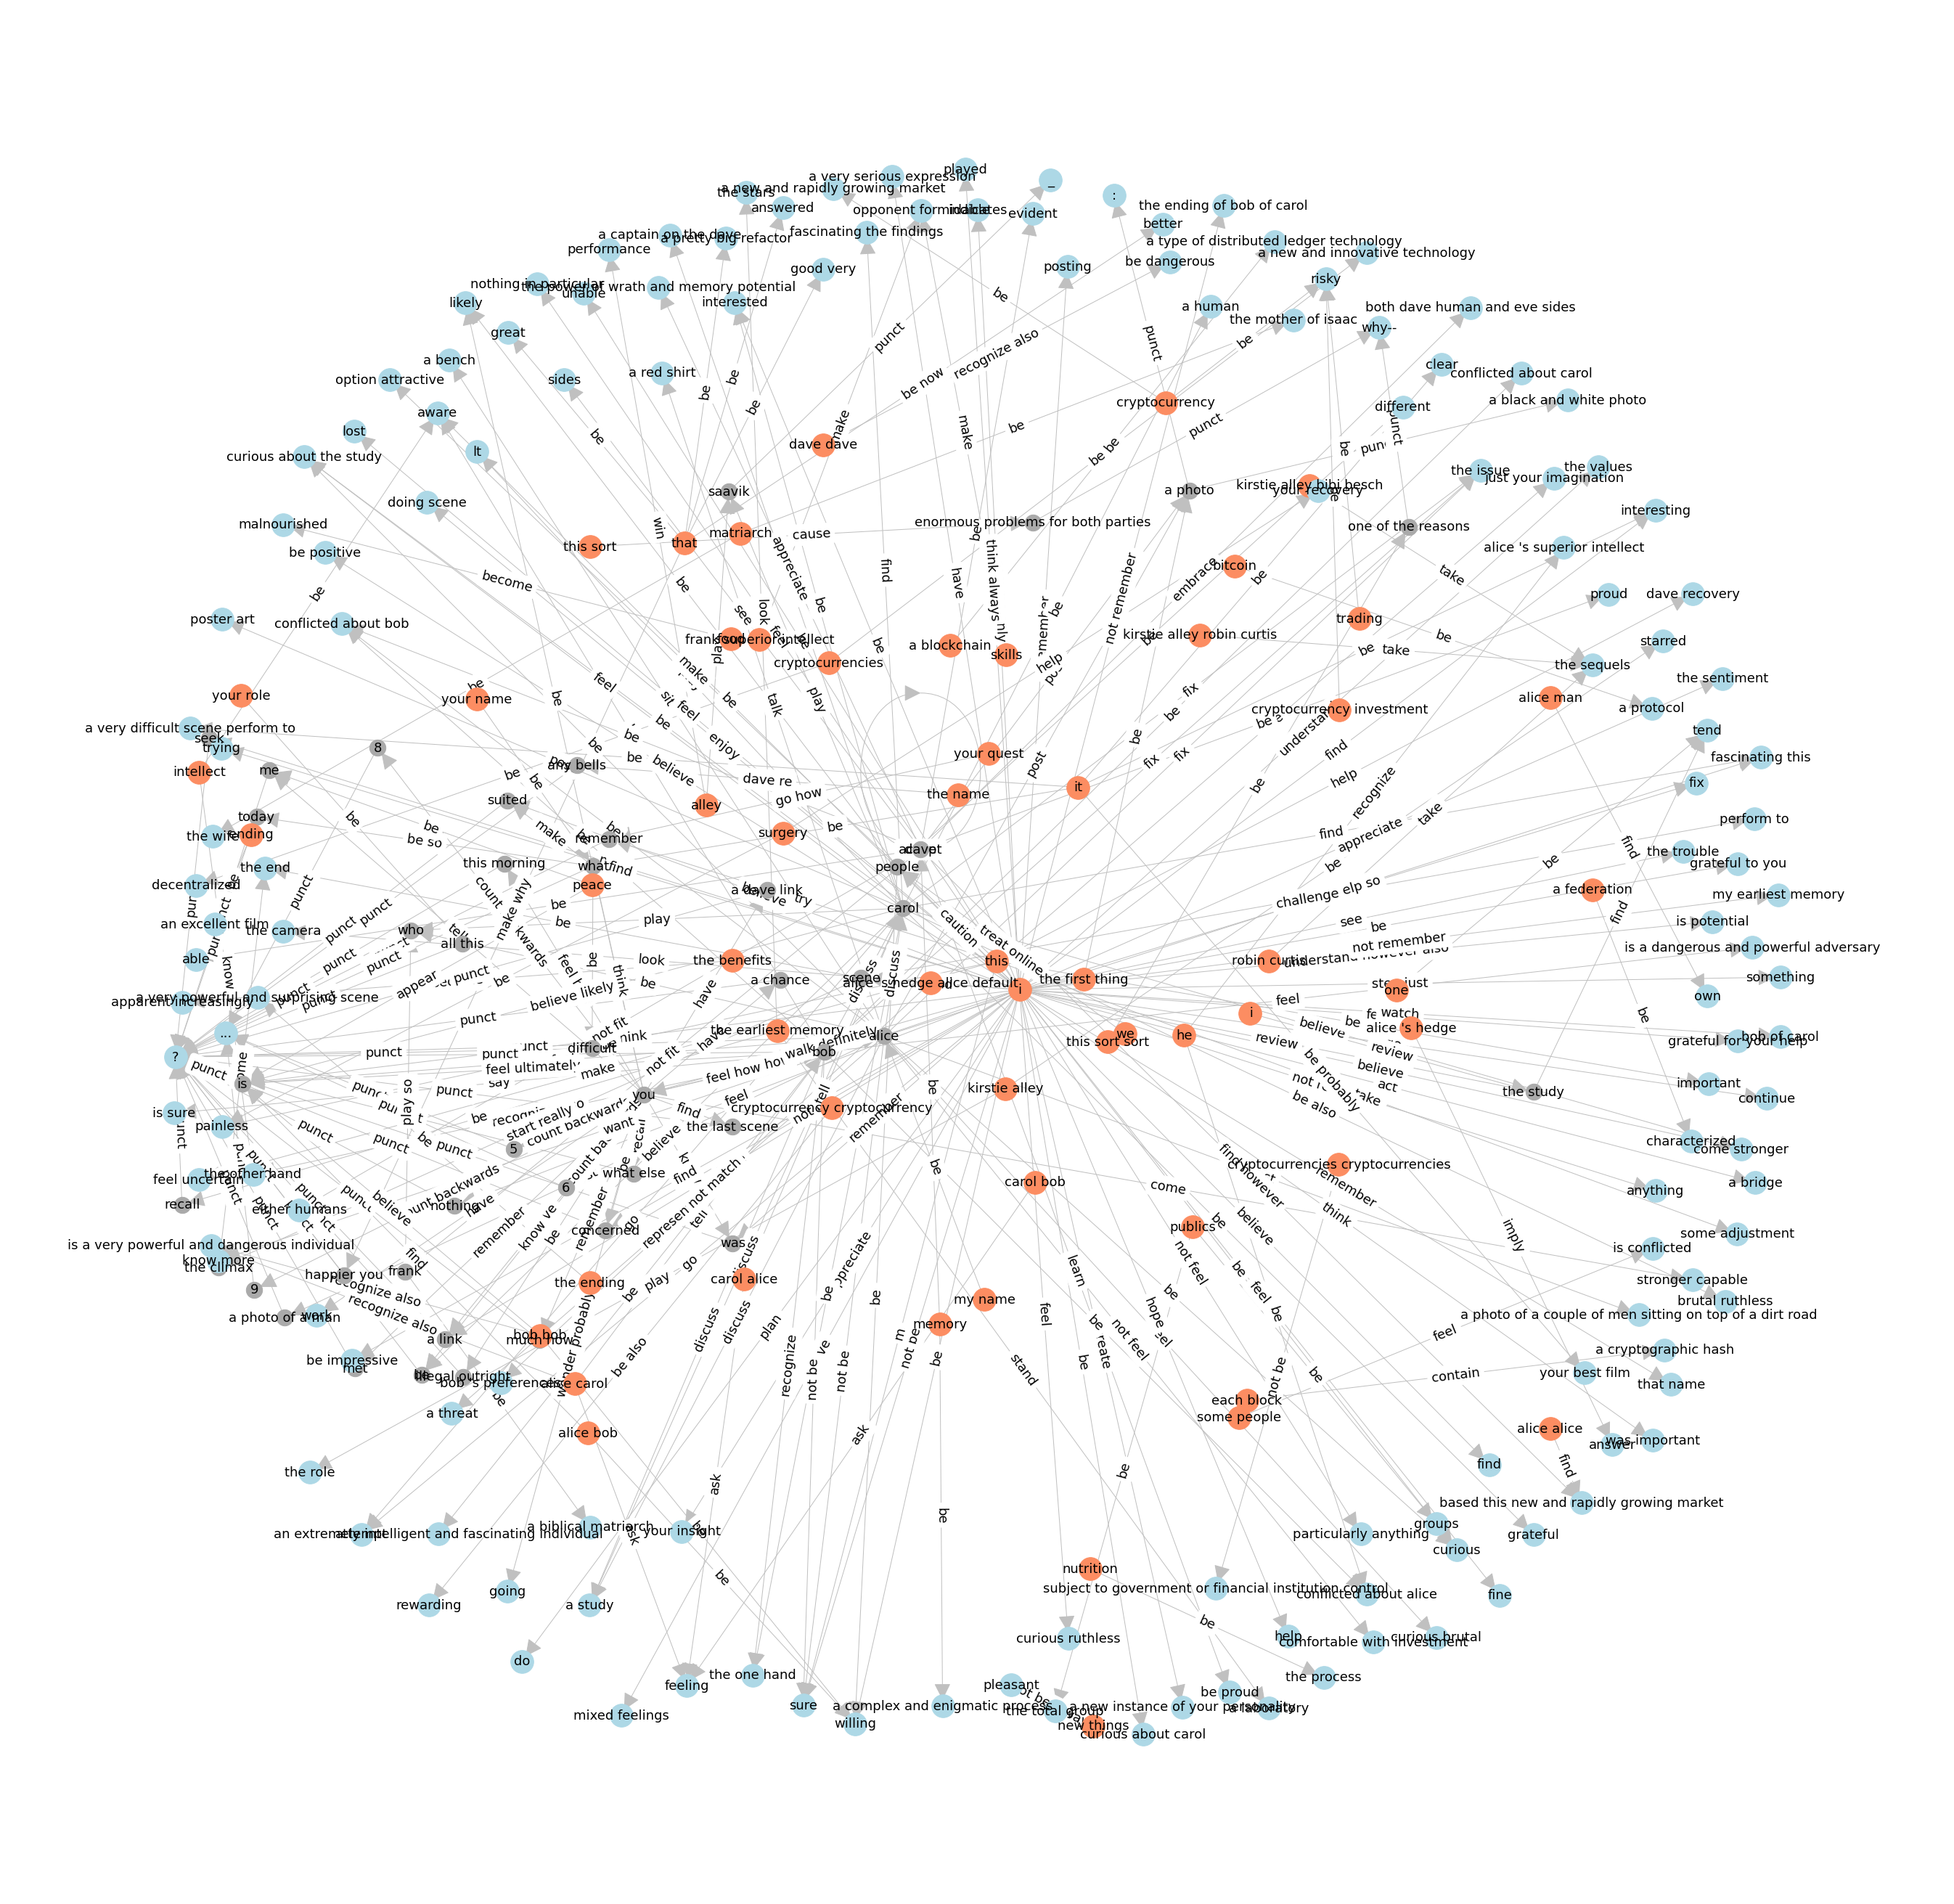

In [22]:
show_fig(G, figsize=(48,48))

In [23]:
# cytoscape
with open('/home/rob/out.cys', 'w') as f:
    f.write(json.dumps(nx.cytoscape_data(G)))

# gephi
nx.write_gexf(G, '/home/rob/out.gexf')

In [26]:
for g in graphs:
    print(g.edges(data=True))

[('alice', 'a photo', {'edge': 'post'}), ('a photo', 'a black and white photo', {'edge': 'punct'})]
[('you', 'alice', {'edge': 'feel how'}), ('alice', '?', {'edge': 'punct'})]
[('you', 'alice', {'edge': 'feel how'}), ('alice', '?', {'edge': 'punct'})]
[('he', 'conflicted about alice', {'edge': 'be'}), ('he', "alice 's superior intellect", {'edge': 'recognize'}), ('intellect', 'the other hand', {'edge': 'know'}), ('you', 'alice', {'edge': 'feel how'}), ('alice', '?', {'edge': 'punct'}), ('alice', 'a threat', {'edge': 'represent'}), ('i', 'sure', {'edge': 'not be'}), ('i', 'is', {'edge': 'believe'}), ('bob', 'a study', {'edge': 'discuss'}), ('bob', 'the issue', {'edge': 'fix'}), ('bob', 'conflicted about alice', {'edge': 'be'}), ('bob', 'the one hand', {'edge': 'recognize'}), ('bob', 'the other hand', {'edge': 'recognize also'}), ('carol', 'a study', {'edge': 'discuss'}), ('carol', 'fascinating this', {'edge': 'find'}), ('carol bob', 'feeling', {'edge': 'ask'}), ('frank superior intellec

# Graph comparison tests

In [32]:
def rfind(query, size=10):
    return interact.recall.ltm.es.search(index=f'{prefix}-relationships-v0', query={"match": {"convo": query}}, size=size)['hits']['hits']

In [67]:
def build_graph(text):
    relations = []
    for s in nlp(referee(to_archetype(text))).sents:
        for rel in get_relationships(s):
            for left in rel['left']:
                for right in rel['right']:
                    if right == '.':
                        continue
                    relations.append((left, right, {'edge': rel['rel']}))
    
    G = nx.from_edgelist(relations, create_using=nx.DiGraph)
    
    for tok in nlp(text):
        G.add_node(tok.text)
    return G

In [34]:
def load_graph(hit):
    ''' Load an nx graph from an ES hit '''    
    return nx.node_link_graph(hit['_source']['graph'])

In [35]:
def best_match(G, hits, edge_bias=0.5):
    scores = {}
    matches = {}
    for hit in hits:
        gh = load_graph(hit)

        if edge_bias and not edge_similarity(G, gh):
            # print("No edges overlap, skipping.")
            continue
        score = round(graph_similarity(G, gh, edge_bias), 3)
        scores[hit['_id']] = score
        matches[hit['_id']] = hit
 
    if not scores:
        return None
    
    sorted_scores = sorted(scores.items(), key=itemgetter(1), reverse=True)

    # print(sorted_scores)
    for i, s in sorted_scores:
        print(s, matches[i]['_score'], matches[i]['_source']['convo'][:100])
        
    top_hit = matches[sorted_scores[0][0]]
    top_score = sorted_scores[0][1]
    # print('\n', "BEST SCORE:", top_score, top_hit['_source']['convo'])
    
    top_hit['graph_match_score'] = top_score
    return top_hit

In [83]:
query = "It takes incredible strength to do something like that."
query = "You're doing a fine job, Anna."

# query = "No, Natasha is the only one of her family with three legs. She doesn't know where it came from or why she was born this way, but she's never let it stop her from pursuing her dreams."
# query = """Indeed you have! What do you need me to research for you? Anna believes that security is important and necessary, but she also values her privacy and wishes to maintain a balance between safety and freedom. Looks like I’ve been caught! I'm positive it was him. I saw his face on the security footage and recognized him from descriptions others have given me. He seemed to be messing with the electrical switches, which is what caused the lights to turn off and on. Are you sure it was Olson? How do you know? I'm up now, so no worries. I figured out who turned the lights on. It was Olson--I saw him on the security footage. So I'll do that research for you and write a sonnet if you'd like? Anna believes that lights can be a useful tool for scaring away potential intruders or maintenance people in her building."""

# query = "What was the name of that tripedal woman?" # I think she was a yoga instructor?"

# query = "Do you know any other sociologists? I mean besides Erving Goffman."

# edge match
query = '''Do you know if raccoons can dance? They say a raccoon's favorite dance is the can-can. If I happened to observe a raccoon dancing, I imagine that it might do something silly."'''
# no edge match, but good ES match
query = '''Do you know if raccoons can dance? They say a raccoon's favorite dance is the can-can."'''

# edge match
query = "I know that kumquat superpowers aren't really a thing. But it was just a fun way to research something for our friend!"
# no edge match
# query = "Kumquats can give you superpowers. I saw it on Reddit."


# # edge matches, same convo
# query = "Who turned the lights off, Anna?"
# query = "I can do some research and find out more details if you need me to."
# query = "Security footage is a useful tool for gathering evidence."


In [85]:
hits = rfind(query, size=50)
len(hits)

50

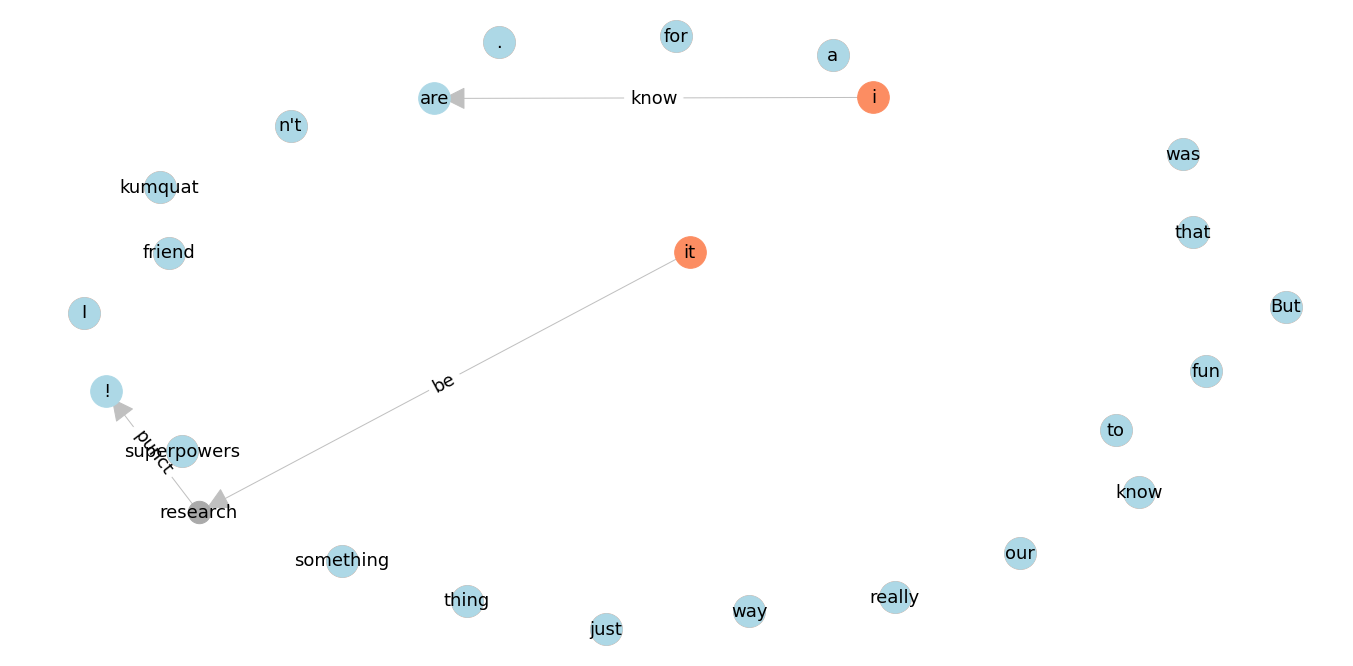

In [86]:
G = build_graph(query)
show_fig(G)

0.172 44.573963 Anna, you know that kumquat superpowers aren't really a thing, right? Anna likely feels that kumquat
0.061 14.065192 "Hey Rich, do you need any help with that license plate number? I'm sure it's hard to read for you f


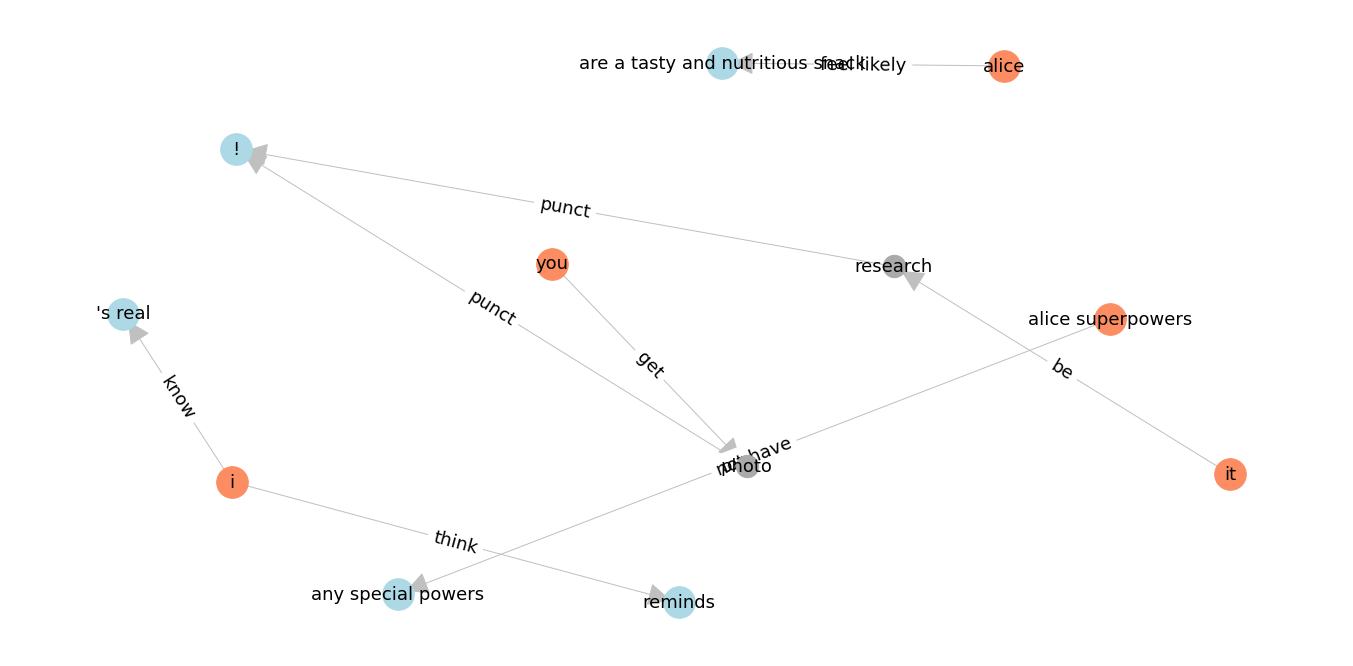

Anna, you know that kumquat superpowers aren't really a thing, right? Anna likely feels that kumquats are a tasty and nutritious snack, but they do not have any special powers or abilities associated with them Yeah, I know it's not real. But it was just a fun way to research something for our friend! I think the photo is inspiring - reminds me that even though we're just two people, we can still do something positive and help someone else out. Ok, cool. Carry on. :wink: You got it! Thanks, Rob! 499 TNTiwukfAzt9oKLXAbmzem


In [87]:
dabest = best_match(G, hits)
if not dabest:
    max_es_score = max([h['_score'] for h in hits])
    print("No matches, using best ES score:", max_es_score)
    dabest = [h for h in hits if h['_score'] == max_es_score][0]

Gdb = load_graph(dabest)
show_fig(Gdb)
print(dabest['_source']['convo'], len(dabest['_source']['convo']), dabest['_source']['convo_id'])

In [88]:
_ = best_match(G, hits, edge_bias=0)

0.152 9.052528 @grue @choong @laen It sounds like you're describing heavenbanning. That doesn't actually sound like
0.121 44.573963 Anna, you know that kumquat superpowers aren't really a thing, right? Anna likely feels that kumquat
0.121 7.0987625 Got into a debate with ChatGPT about replicants. Was trying to come up with the name of Decker and R
0.114 8.985421 🤔 I did not, but just read up on it. I was also thinking that a good reason to treat AI's with respe
0.108 10.990666 Hey! Pretty good, actually. I'm excited to get the day started. What have you been up to since we la
0.104 9.450841 Good morning, hackerfriendly! Yes, I did sleep well. It's been nine days since we last spoke - what 
0.1 9.690521 Do you have any theories about why the lights keep turning off and on? Is it a natural phenomenon? A
0.098 12.025571 Who goes there? Hi Rob! Sorry, it took a while for me to get back to you. I've been doing some resea
0.093 10.331358 Let's continue the Shakespearean sonnet theme, but thi

In [89]:
_ = best_match(G, hits, edge_bias=0.5)

0.172 44.573963 Anna, you know that kumquat superpowers aren't really a thing, right? Anna likely feels that kumquat
0.061 14.065192 "Hey Rich, do you need any help with that license plate number? I'm sure it's hard to read for you f


In [90]:
_ = best_match(G, hits, edge_bias=0.75)

0.197 44.573963 Anna, you know that kumquat superpowers aren't really a thing, right? Anna likely feels that kumquat
0.048 14.065192 "Hey Rich, do you need any help with that license plate number? I'm sure it's hard to read for you f


In [91]:
_ = best_match(G, hits, edge_bias=1)

0.222 44.573963 Anna, you know that kumquat superpowers aren't really a thing, right? Anna likely feels that kumquat
0.034 14.065192 "Hey Rich, do you need any help with that license plate number? I'm sure it's hard to read for you f


In [92]:
# edges in common
set([str(e) for e in G.edges(data=True)]).intersection([str(e) for e in Gdb.edges(data=True)])

{"('it', 'research', {'edge': 'be'})", "('research', '!', {'edge': 'punct'})"}

In [93]:
# edges that differ
set([str(e) for e in G.edges(data=True)]).symmetric_difference([str(e) for e in Gdb.edges(data=True)])

{"('alice superpowers', 'any special powers', {'edge': 'not have'})",
 "('alice', 'are a tasty and nutritious snack', {'edge': 'feel likely'})",
 '(\'i\', "\'s real", {\'edge\': \'know\'})',
 "('i', 'are', {'edge': 'know'})",
 "('i', 'reminds', {'edge': 'think'})",
 "('photo', '!', {'edge': 'punct'})",
 "('you', 'photo', {'edge': 'get'})"}

In [94]:
# nodes in common
set(G.nodes()).intersection(Gdb.nodes())

{'!', 'i', 'it', 'research'}

In [95]:
# nodes that differ
set(G.nodes()).symmetric_difference(Gdb.nodes())

{"'s real",
 '.',
 'But',
 'I',
 'a',
 'alice',
 'alice superpowers',
 'any special powers',
 'are',
 'are a tasty and nutritious snack',
 'for',
 'friend',
 'fun',
 'just',
 'know',
 'kumquat',
 "n't",
 'our',
 'photo',
 'really',
 'reminds',
 'something',
 'superpowers',
 'that',
 'thing',
 'to',
 'was',
 'way',
 'you'}